# Temperature Rise based on GHG Emissions

In this project, I'll analyze datasets that have both spatial and temporal features to understand the impact of greenhouse gas (GHG) emissions on temperature. To prepare the data, I'll test two methods for handling the spatial aspect of the data (geohashing) and two methods for calculating the anomalous temperature feature (globally vs regionally). The results will be compared to data from NASA for evaluation. After the date is prepared, I'll use a simple linear regression model to try predicting the anomalous temperature based on GHG emissions.

The code and data can be found on my github (link).

*Note: Originally, I analyzed this dataset with a partner for a project for the Data Science 200 course (link) at UC Berkeley. I've revampled the data cleaning, analysis, and modeling to investigate some lingering questions after the class.*

## Where is the data coming from?
Three datasets are used:
- **Daily Temperature**: Obtained from the Global Historical Climatology Network (GHCN). The dataset for each year was preprocessed (notebook included) to only include data from stations with both temperature and precipitation measurements.
- **GHG Emissions**: Obtained from the Environmental Protection Agency (EPA) and contains the type and total amount of CO2-equivalents of gas emissions by facilities in the US.
- **Accepted Anomalous Temperature**: Obtained from NASA (climate.nasa.gov) containing accepted values for the increase in global temperature.

## Import data and libraries
First, let's import the necessary libraries and data files.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import random
from mpl_toolkits.basemap import Basemap
import pygeohash as pgh
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
import warnings
warnings.filterwarnings("ignore")

# load data
global_weather = {'y2011': pd.read_csv('data/daily_global_weather_2011.csv'),
                  'y2012': pd.read_csv('data/daily_global_weather_2012.csv'),
                  'y2013': pd.read_csv('data/daily_global_weather_2013.csv'),
                  'y2014': pd.read_csv('data/daily_global_weather_2014.csv'),
                  'y2015': pd.read_csv('data/daily_global_weather_2015.csv'),
                  'y2016': pd.read_csv('data/daily_global_weather_2016.csv'),
                  'y2017': pd.read_csv('data/daily_global_weather_2017.csv'),
                  'y2018': pd.read_csv('data/daily_global_weather_2018.csv'),
                  'y2019': pd.read_csv('data/daily_global_weather_2019.csv')
                 }
emissions_gas_type = pd.read_csv('data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv')
nasa = pd.read_csv('data/NASA_Global_Mean_Estimates_based_on_Land_and_Ocean_Data_graph.txt', skiprows=5, sep='\s+',
                   names = ['Year','No_Smoothing','Lowess(5)'])

## Preparing the data
To understand how GHG emissions impact temperature, we'll have to account for the spatial and temporal aspects of the data when engineering the two features we'll need for our models:
* Anomalous temperature: The deviation/change in average temperature from average temperature of a reference year
* Accumulated emissions: The cumulative sum of emissions based on previous years of data
These features can be calculated globally or regionally. We'll use geohashing get regional information. Additionally, accumulated emissions can be calculated for all GHG gases or calculated for each GHG gas type, which would increase the complexity of our model.

### Preparing the Global Weather Data
First, what does that data look like? `global_weather` contains the station locations where measurements are taken and the daily precipitation in $mm\times10$ (`PRCP`) and the daily average temperature in $Celsius\times10$ (`TAVG`) at a station. The time and location for each measurement is also recorded.

In [2]:
global_weather['y2011'].head()

,Unnamed: 0,Station,Date,PRCP,Latitude,Longitude,Elevation,TAVG
0,0,AEM00041194,2011-01-01,0.0,25.2550,55.3640,10.4,203.0
1,1,AG000060390,2011-01-01,8.0,36.7167,3.2500,24.0,118.0
2,2,AG000060590,2011-01-01,0.0,30.5667,2.8667,397.0,89.0
3,3,AG000060611,2011-01-01,0.0,28.0500,9.6331,561.0,113.0
4,4,AGE00147708,2011-01-01,8.0,36.7200,4.0500,222.0,113.0


**How is the data stored?** Is there anything that needs to be adjusted? Upon inspection, the dtype for `Date` could be more useful as datetime to evaluate how variables change over time. All columns have the same number of entries, so there are no null values in the dataset.

In [3]:
global_weather['y2011'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021468 entries, 0 to 1021467
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1021468 non-null  int64  
 1   Station     1021468 non-null  object 
 2   Date        1021468 non-null  object 
 3   PRCP        1021468 non-null  float64
 4   Latitude    1021468 non-null  float64
 5   Longitude   1021468 non-null  float64
 6   Elevation   1021468 non-null  float64
 7   TAVG        1021468 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 62.3+ MB


**Where is the data collected?** What is the spatial distribution? It will be helpful to understand how the stations are spread out across the globe. To get an idea of the spatial distribution, I'll plot the station locations from one year (2014).

It's easy to see stations/measurements are not taken uniformly around the globe, so if we were to take an average of temperature measurements, regions with more data points would be over-represented. To account for this, we can use geohashing and calculate averages by region before averaging around the globe.

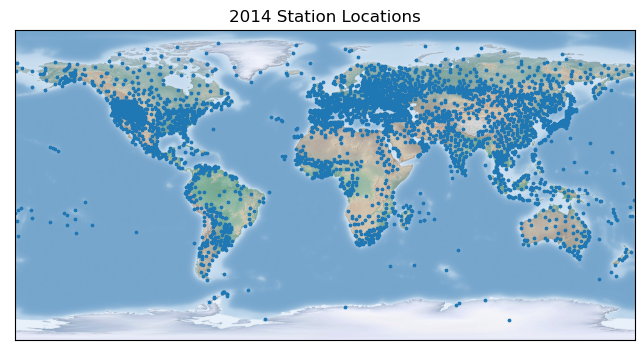

In [4]:
# map station locations from 2014
stations14 = global_weather['y2014'].drop_duplicates(subset=['Station'])
lat14 = stations14['Latitude'].values
long14 = stations14['Longitude'].values

fig = plt.figure(figsize=(8, 6), edgecolor='w');
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, );
m.shadedrelief();
m.scatter(long14, lat14, latlon = True, s=3);
plt.title('2014 Station Locations');

Let's inspect the data a bit more. I'll plot the distribution of the daily average temperature on a given day. There should be a broad range of Temperatures due differences in climates around the globe. This distribution is not uniform due to the uneven distribution of stations (and climates) around the globe.

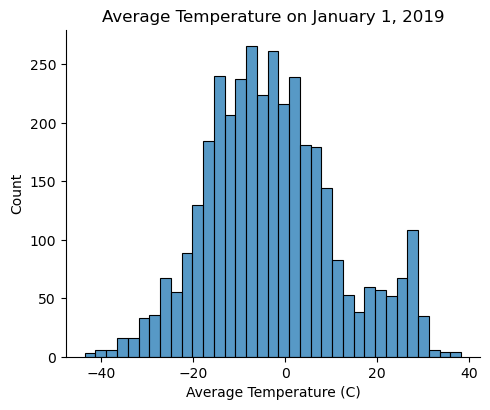

In [5]:
# plot average temperature distribution on Jan. 1, 2020
weather_on_Jan119 = global_weather['y2019'][global_weather['y2019']['Date']=='2019-01-01']
sns.displot(weather_on_Jan119['TAVG']/10, height = 4, aspect = 5/4); # divide by 10 to get to Celsius units
plt.title('Average Temperature on January 1, 2019');
plt.xlabel('Average Temperature (C)');

**Cleaning tasks for `global_weather` data:**

After some initial inspection, let's move on to cleaning this dataset. To prepare this dataset for modeling, we'll need to do a few things first:

* **Address the spatial distribution**: To account for the non-uniform spatial distribution of stations/measurement locations, we will add a new column to our table, `geohash`, that represents a given region.

* **Create useful time columns**: For grouping, it will be convenient to convert the Date column type to datetime and create month and day columns.

* **Convert the units of `TAVG` and `PRCP`**: We will convert `TAVG` and `PRCP` to Celsius and mm, which are more recognizable units.

To do this, I'll define some cleaning functions:

In [6]:
def add_geohash(df, gh_col = 'geohash'):
    '''
    a function to create the geohash column using pygeohash
    gh_col is the output column containing the geohash/code
    '''   
    df[gh_col] = df.apply(lambda x: pgh.encode(x.Latitude, x.Longitude, precision = 2), axis = 1)
    return df

def add_my_geohash(df, step_size=10):
    '''
    a function for geohashing using my own algorithm
    step_size is the size in latitude and longitude for each geohash region
    '''
    # create arrays with the limits on latitude and longitude
    gh_code = 0
    lat_bounds = np.arange(-90,90,step_size)
    long_bounds = np.arange(-180,180,step_size)
    
    # iterate over the full range of latitudes and longitudes
    for lat_border in lat_bounds:
        for long_border in long_bounds:
            df.loc[((df['Latitude']>=lat_border)&(df['Latitude']<(lat_border+step_size)))&
                   ((df['Longitude']>=long_border)&(df['Longitude']<(long_border+step_size))),'my_gh'] = gh_code
            gh_code += 1 
    return df

def create_my_gh_dict(step_size = 10):
    '''
    a function to create a dictionary to decode my geohashing
    keys are geohash/code
    values are lower and upper latitude boundaries and lower and upper longitude boundaries
    step_size is the size in latitude and longitude for each geohash region
    '''
    # create a dictionary so the gh_codes can be decoded
    my_gh_dict = {}
    
    # create arrays with the limits on latitude and longitude
    gh_code = 0
    lat_bounds = np.arange(-90,90,step_size)
    long_bounds = np.arange(-180,180,step_size)
    
    # iterate over the full range of latitudes and longitudes
    for lat_border in lat_bounds:
        for long_border in long_bounds:
            my_gh_dict[gh_code] = [lat_border, lat_border+step_size, long_border, long_border+step_size]
            gh_code += 1  
    return my_gh_dict

def convert_units(df):
    '''
    a function to convert temperature and preciptation columns to Celsius and mm, respectively
    '''
    df['TAVG_C'] = df['TAVG']/10
    df['PRCP_mm'] = df['PRCP']/10
    return df

def convert_time(df, old_dt_col = 'Date', new_dt_col = 'Date_dt'):
    '''
    a function to convert the Date column to datetime
    this function also adds a month and year column, to make grouping more readable
    '''
    df[new_dt_col] = df[old_dt_col].astype('datetime64[ns]')
    df['year'] = df[new_dt_col].dt.year
    df['month'] = df[new_dt_col].dt.month
    return df

**Feature Engineering: Calculating Anomalous Temperature**

It turns out when people talk about global temperature rise, this is foten represented as the *anomalous temperature*, which is this change in temperature from a reference time period. Since our oldest data is from 2011, 2011 will be our reference point. I'll create new features in the dataframe for the anomalous temperature, as well as the anomalous precipitation.

There are a couple ways to calculate this:
* Globally: Calculate the average temperature of a region in a year > Average the values together for a global average > Substract the value from the reference year
* Regionally: Calculate the average temperature of a region in a year > Subtract the average temperature for that region from the reference year > Average the anomalous values together.

The results also depend on how coarse-grained the geohashing method is. I'll evaluate the effectiveness of two different methods for geohashing (pygeohash and my geohashing method) by comparing the results to data from NASA.

In [7]:
def calculate_annual_vals(df, gh_col = 'my_gh'):
    '''
    this function calculates anomalous temperature based on GLOBAL averages by:
    > Calculating the average temperature of a region in a year
    > Averaging the values together for a global average
    > Substracting the value from the reference year
    '''
    # calculate the average by year and by region. then calculate the average over all regions for a given year
    yearly_df = df.groupby(['year',gh_col]).mean(['TAVG_C','PRCP_mm'])[['TAVG_C','PRCP_mm']].reset_index().groupby(
                            ['year']).mean(['TAVG_C','PRCP_mm'])[['TAVG_C','PRCP_mm']].reset_index()
    
    # calculate the anomalous temperature for a given year using the first data year as a reference
    yearly_df['TAVG_C_diff'] = yearly_df['TAVG_C'] - yearly_df.loc[yearly_df['year'] == yearly_df['year'].min(),'TAVG_C'].values[0]
    yearly_df['PRCP_diff'] = yearly_df['PRCP_mm'] - yearly_df.loc[yearly_df['year'] == yearly_df['year'].min(),'PRCP_mm'].values[0]
    return yearly_df

def calculate_annual_vals_by_region(df):
    '''
    this function calculates anomalous temperature based on REGIONAL averages by:
    > Calculating the average temperature of a region in a year
    > Substracting the value from the reference year for that region
    This method was broken into to parts to easily access the dataframe with anomalous values by region
    '''
    # calculate the average by year and by region.
    ybr_df = df.groupby(['year','my_gh']).mean(['TAVG_C','PRCP_mm'])[['TAVG_C','PRCP_mm']].reset_index()
    
    # calculate the anomalous temperature for a given year/region using the first data year as a reference
    baseline_Ts = ybr_df.groupby('my_gh')['TAVG_C'].first()
    baseline_Ps = ybr_df.groupby('my_gh')['PRCP_mm'].first()
    ybr_df['TAVG_C_diff'] = ybr_df['TAVG_C'] - ybr_df['my_gh'].map(baseline_Ts)
    ybr_df['PRCP_diff'] = ybr_df['PRCP_mm'] - ybr_df['my_gh'].map(baseline_Ps)
    return ybr_df

def calculate_global_vals(df):
    '''
    this function calculates a GLOBAL anomalous temperature based on REGIONAL averages by:
    > Averaging the anomalous values by region.
    '''
    # calculate the average anomolous temperature across all regions
    global_df = df.groupby('year').mean(['TAVG_C_diff','PRCP_diff'])[['TAVG_C_diff','PRCP_diff']].reset_index()
    return global_df

**Applying data cleaning functions with `pipe`**

Now that the functions are defined, a convenient way to apply them to the dataset is with the `pipe` funciton. It's good to verify the changes have been made by inspecting the dataframe and the dtypes.

In [8]:
# concatenate the dataframes
global_weather_all = pd.concat(global_weather, ignore_index=True)

# add geohash columns and clean time and units
global_weather_all = global_weather_all.pipe(add_geohash).pipe(add_my_geohash).pipe(convert_units).pipe(convert_time)
global_weather_all[global_weather_all['year']==2014].dtypes
global_weather_all.head()

,Unnamed: 0,Station,Date,PRCP,Latitude,Longitude,Elevation,TAVG,geohash,my_gh,TAVG_C,PRCP_mm,Date_dt,year,month
0,0,AEM00041194,2011-01-01,0.0,25.2550,55.3640,10.4,203.0,th,419.0,20.3,0.0,2011-01-01,2011,1
1,1,AG000060390,2011-01-01,8.0,36.7167,3.2500,24.0,118.0,sn,450.0,11.8,0.8,2011-01-01,2011,1
2,2,AG000060590,2011-01-01,0.0,30.5667,2.8667,397.0,89.0,sj,450.0,8.9,0.0,2011-01-01,2011,1
3,3,AG000060611,2011-01-01,0.0,28.0500,9.6331,561.0,113.0,sh,414.0,11.3,0.0,2011-01-01,2011,1
4,4,AGE00147708,2011-01-01,8.0,36.7200,4.0500,222.0,113.0,sn,450.0,11.3,0.8,2011-01-01,2011,1


It would be good to know just how many regions are created with each geohashing method. There are fewer codes using my approach (305) compared to pygeohash (424), so my approach is more coarse-grained. I'll also plot this distribution to get an idea of how uniform the stations are spread in the geohash regions. Note that some regions have a large amount (>20,000) stations/measurement locations, while other regions have less than 10. 

Number of regions with pygeohash: 424
Number of regions with my geohashing: 305


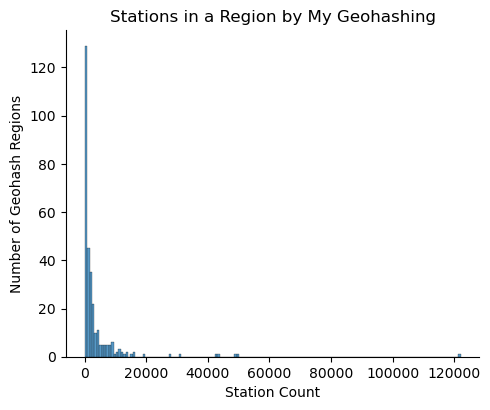

In [9]:
# compare number of stations in each region
pygeohash_reg = global_weather_all[global_weather_all['year']==2014]['geohash'].unique().size
my_gh_reg = global_weather_all[global_weather_all['year']==2014]['my_gh'].unique().size
print('Number of regions with pygeohash:', pygeohash_reg)
print('Number of regions with my geohashing:', my_gh_reg)

# plot distribution
sns.displot(global_weather_all[global_weather_all['year']==2014]['my_gh'].value_counts(), height = 4, aspect = 5/4)
plt.title('Stations in a Region by My Geohashing');
plt.xlabel('Station Count');
plt.ylabel('Number of Geohash Regions');

Now the dataframes are ready to calculate the anomalous values.

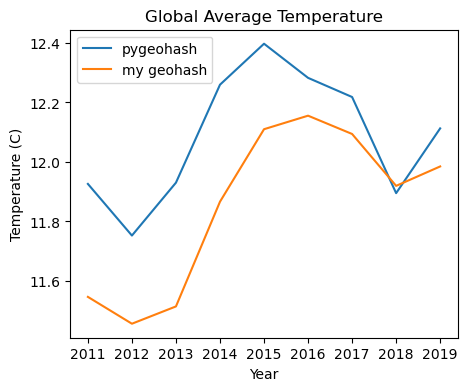

In [10]:
# calculate the average global temperature and anomalous global temperature by each geohashing method
yearly_df = global_weather_all.pipe(calculate_annual_vals, gh_col = 'geohash')
my_yearly_df = global_weather_all.pipe(calculate_annual_vals, gh_col = 'my_gh')

# plot to compare the average global temperature calculated
plt.figure(figsize=(5,4))
plt.plot(yearly_df['year'], yearly_df['TAVG_C'], label = 'pygeohash');
plt.plot(my_yearly_df['year'], my_yearly_df['TAVG_C'], label = 'my geohash');
plt.xlabel('Year');
plt.legend();
plt.ylabel('Temperature (C)');
plt.title('Global Average Temperature');

Although the shapes of the plots are similar, the temperatures calculated are different. This may be due to the differences in geohashing approach. In pygeohash, the given latitudes and longitudes are assigned codes, so regions without stations/measurements are unweighted in the results. In my geohashing approaching, the code looks for data points within all regions of the globe. It is also a coarser approach, which may help by adding weight to regions with few data points.

To compare these results to NASA's results, we'll need to calculate the anomalous temperature, which had two calculation methods to evaluate. Using the first method, I'll also compare geohashing methods by comparing the plots and calculating thet correlation.

Before I can begin the comparison, I'll need slice out the data from 2011-2019 and recalculate NASA's anomalous temperature so that all datasets use the same reference year. After plotting, it looks like my geohashing approach follows the shape of NASA's results better, but pygeohash calculates values closer to NASA's.

When using global averages, the correlation between pygeohash's and NASA's results is 0.66
When using global averages, the correlation between my geohash's and NASA's results is 0.93
When using regional averages, the correlation between my geohash's and NASA's results is 0.91


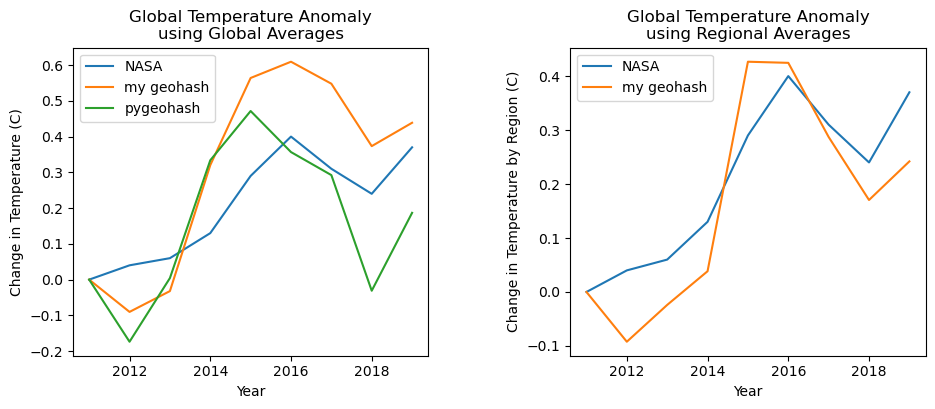

In [11]:
# use NASA data from relevant years and recalculate for a 2011 reference
nasa_comparison = nasa.loc[(nasa['Year']>=2011) & (nasa['Year']<2020)]
nasa_comparison['No_Smooth_Rel_2011'] = nasa_comparison['No_Smoothing'] - nasa_comparison.loc[nasa_comparison['Year']==2011]['No_Smoothing'].values[0]

# Comparing geohashing methods for anomalous temperature (calculated by global change)
plt.figure(1,figsize=(11,4))
plt.subplots_adjust(wspace=0.4)
ax1 = plt.subplot(1,2,1)
ax1.plot(nasa_comparison['Year'], nasa_comparison['No_Smooth_Rel_2011'], label = 'NASA');
ax1.plot(my_yearly_df['year'], my_yearly_df['TAVG_C_diff'], label = 'my geohash');
ax1.plot(yearly_df['year'], yearly_df['TAVG_C_diff'], label = 'pygeohash');
ax1.set_xlabel('Year');
ax1.legend();
ax1.set_ylabel('Change in Temperature (C)');
ax1.set_title('Global Temperature Anomaly\nusing Global Averages');

# calculate correlation between my geohashing results and pygeohash results vs NASA
compar1_df = yearly_df[['year','TAVG_C_diff']].merge(
    nasa_comparison[['Year','No_Smooth_Rel_2011']],left_on='year', right_on='Year').drop('year', axis=1).rename(
    columns = {'TAVG_C_diff': 'pgh_T_diff', 'No_Smooth_Rel_2011':'nasa_T_diff'}).merge(
    my_yearly_df[['year','TAVG_C_diff']],left_on='Year', right_on='year').drop('year', axis = 1).rename(
    columns = {'TAVG_C_diff': 'mygh_T_diff'})
pgh_v_Nasa_corr = compar1_df['pgh_T_diff'].corr(compar1_df['nasa_T_diff'])
mygh_v_Nasa_corr = compar1_df['mygh_T_diff'].corr(compar1_df['nasa_T_diff'])
print('When using global averages, the correlation between pygeohash\'s and NASA\'s results is', round(pgh_v_Nasa_corr,2))
print('When using global averages, the correlation between my geohash\'s and NASA\'s results is', round(mygh_v_Nasa_corr,2))


# Calculating anomalous temperature by region before global averaging & plotting
regional_df = global_weather_all.pipe(calculate_annual_vals_by_region)
global_df = regional_df.pipe(calculate_global_vals)

ax2 = plt.subplot(1,2,2)
ax2.plot(nasa_comparison['Year'], nasa_comparison['No_Smooth_Rel_2011'], label = 'NASA');
ax2.plot(global_df['year'], global_df['TAVG_C_diff'],label = 'my geohash')
ax2.set_xlabel('Year');
ax2.legend();
ax2.set_ylabel('Change in Temperature by Region (C)');
ax2.set_title('Global Temperature Anomaly\nusing Regional Averages');

# calculate correlation between my geohashing results vs NASA
compar2_df = global_df[['year','TAVG_C_diff']].merge(
    nasa_comparison[['Year','No_Smooth_Rel_2011']],left_on='year', right_on='Year').drop('year', axis=1).rename(
    columns = {'TAVG_C_diff': 'myghRegional_T_diff', 'No_Smooth_Rel_2011':'nasa_T_diff'})
myghRegional_v_Nasa_corr = compar2_df['myghRegional_T_diff'].corr(compar2_df['nasa_T_diff'])
print('When using regional averages, the correlation between my geohash\'s and NASA\'s results is', round(myghRegional_v_Nasa_corr,2))

The deviations between my results and NASA's can be attributed to data source and geohashing methods. Given the strong correlation between my calculations with NASA's, I feel confident with the cleaning process. However, I'll soon see that the GHG emissions data is annual and only located in the US (values are reported by the US EPA). Using annual data will leave me with 10 data points--not great for training and evaluating a model! While I'll still look at the correlation between *accumulated* GHG emissions and anomalous temperature, I want to develop a model relating the local GHG emissions to local anomalous temperature. Fortunately, I've already calculated the dataframe with yearly anomalous temperature b region, `regional_df`. To see how the anomalous temperature changes by region, I can utilize pivot tables for plotting. Since there are too many regions to plot at once (>300), I'll start by inspecting the 10 regions.

This dataset is ready to merge with the GHG emissions data.

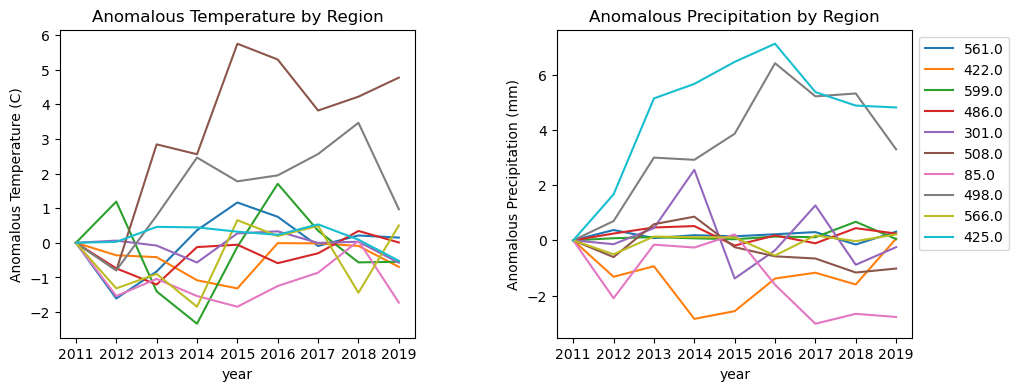

In [12]:
# plot annual anomalous temperature and precipitation in given regions
regional_pivot = regional_df.pivot(index = 'year', columns = 'my_gh', values = 'TAVG_C_diff').dropna(axis=1)
regional_pivot_PRCP = regional_df.pivot(index = 'year', columns = 'my_gh', values = 'PRCP_diff').dropna(axis=1)
my_gh_codes = list(regional_pivot.columns)
random.seed(12)
regions = random.sample(my_gh_codes, 10)

plt.figure(1,figsize=(11,4))
plt.subplots_adjust(wspace=0.4)
ax1 = plt.subplot(1,2,1)
regional_pivot[regions].plot(ax = ax1,xticks=regional_pivot.index, ylabel='Anomalous Temperature (C)',legend=None)
ax1.set_title('Anomalous Temperature by Region')
ax2 = plt.subplot(1,2,2)
regional_pivot_PRCP[regions].plot(ax = ax2,xticks=regional_pivot_PRCP.index, ylabel='Anomalous Precipitation (mm)');
ax2.set_title('Anomalous Precipitation by Region')
ax2.legend(bbox_to_anchor =(1, 1));

### GHG Emissions Data
`emissions_gas_type` gives information on gas emissions (type, amount in $CO_2$ equivalents, $CO_2e$) in a year by a particular facility. There are extra columns, and the names are long. So, let's select desirable columns and rename columns to simpler names. Let's also check for null values.

In [13]:
emissions_gas_type.head()

,V_GHG_EMITTER_GAS.ADDRESS1,V_GHG_EMITTER_GAS.ADDRESS2,V_GHG_EMITTER_GAS.CITY,V_GHG_EMITTER_GAS.CO2E_EMISSION,V_GHG_EMITTER_GAS.COUNTY,V_GHG_EMITTER_GAS.FACILITY_ID,V_GHG_EMITTER_GAS.GAS_CODE,V_GHG_EMITTER_GAS.GAS_NAME,V_GHG_EMITTER_GAS.LATITUDE,V_GHG_EMITTER_GAS.LONGITUDE,V_GHG_EMITTER_GAS.STATE,V_GHG_EMITTER_GAS.STATE_NAME,V_GHG_EMITTER_GAS.YEAR,V_GHG_EMITTER_GAS.ZIP,V_GHG_EMITTER_GAS.FACILITY_NAME,V_GHG_EMITTER_GAS.COUNTY_FIPS
0,1919 S. BROADWAY,NaN,GREEN BAY,58024.000,BROWN COUNTY,1000589,BIOCO2,Biogenic CO2,44.492500,-88.032300,WI,WISCONSIN,2017,54304,GEORGIA-PACIFIC CONSUMER OPERATIONS LLC,55009.0
1,850 12TH AVE,NaN,NEW YORK,134.500,New York,1000766,CH4,Methane,40.771100,-73.991100,NY,NEW YORK,2018,10019,59th Street,36061.0
2,3379 HWY 482,NaN,Noble,6.854,SABINE,1009343,N2O,Nitrous Oxide,31.621528,-93.724774,LA,LOUISIANA,2012,71462,Baker Road Treater,22085.0
3,1012 BEAUCHAMP ST,NaN,GREENVILLE,53562.000,WASHINGTON COUNTY,1003557,CH4,Methane,33.392476,-91.017584,MS,MISSISSIPPI,2017,38701,TEXAS GAS TRANSMISSION - GREENVILLE STATION,28151.0
4,487 CORN CREEK ROAD,NaN,BEDFORD,7635064.700,Trimble,1006542,CO2,Carbon Dioxide,38.584700,-85.411700,KY,KENTUCKY,2018,40006,Trimble County,21223.0


In [14]:
# clean the emissions data by removing unnecessary columns and simplifying the names
simple_emissions = emissions_gas_type[['V_GHG_EMITTER_GAS.LATITUDE','V_GHG_EMITTER_GAS.LONGITUDE',
                                       'V_GHG_EMITTER_GAS.CO2E_EMISSION','V_GHG_EMITTER_GAS.GAS_CODE',
                                       'V_GHG_EMITTER_GAS.YEAR','V_GHG_EMITTER_GAS.ZIP','V_GHG_EMITTER_GAS.CITY',
                                       'V_GHG_EMITTER_GAS.STATE']].rename(
                                        {'V_GHG_EMITTER_GAS.LATITUDE': 'Latitude',
                                         'V_GHG_EMITTER_GAS.LONGITUDE': 'Longitude',
                                         'V_GHG_EMITTER_GAS.CO2E_EMISSION': 'CO2 Emissions',
                                         'V_GHG_EMITTER_GAS.GAS_CODE': 'Gas Code',
                                         'V_GHG_EMITTER_GAS.YEAR': 'Year', 'V_GHG_EMITTER_GAS.ZIP': 'Zip',
                                         'V_GHG_EMITTER_GAS.CITY': 'City', 'V_GHG_EMITTER_GAS.STATE': 'State'}, axis = 1)
simple_emissions['City'] = simple_emissions['City'].str.lower()
simple_emissions.isnull().sum()

Latitude         226
Longitude        226
CO2 Emissions      0
Gas Code           0
Year               0
Zip                0
City               0
State              0
dtype: int64

**Handling null values**

Some facilities are missing latitude and longitude coordinate, which will cause an issue when we try to encode the location with geohashing. To see if these records are important or if they can be dropped, let's try to understand what facilities are missing latitude and longitude.

array(['amber, OK', 'austin, TX', 'balmorhea, TX', 'blessing, TX',
       'bridgeport, TX', 'canonsburg, PA', 'carlsbad, NM',
       'channelview, TX', 'coyanosa, TX', 'dallas, TX', 'denver, CO',
       'dillonvale, OH', 'dunbar, WV', 'east bernard, TX',
       'edinburgh, TX', 'el dorado, AR', 'eldred, NY', 'florence, AZ',
       'fort stockton, TX', 'frisco, TX', 'goldsmith, TX',
       'grand cane, LA', 'houston, TX', 'jasper, TX', 'katy, TX',
       'kermit, TX', 'lecompte, LA', 'louisville, OH', 'mentone, TX',
       'midland, TX', 'new albany, MS', 'new orleans, LA',
       'oklahoma city, OK', 'pecos, TX', 'pelkie, MI', 'pensacola, FL',
       'robstown, TX', 'san antonio, TX', 'shreveport, LA', 'stuart, OK',
       'the woodlands, TX', 'tulsa, OK', 'washington, DC',
       'waynesboro, TN', 'west union, WV', 'wyomissing, PA'], dtype=object)

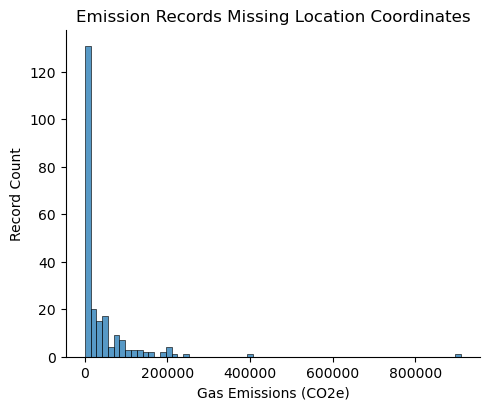

In [15]:
emissions_missing_loc = simple_emissions[simple_emissions['Latitude'].isnull()]

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="abird")

locations = (emissions_missing_loc['City']+', '+emissions_missing_loc['State']).sort_values().unique()
display(locations)

sns.displot(emissions_missing_loc['CO2 Emissions'], height = 4, aspect = 5/4)
plt.title('Emission Records Missing Location Coordinates')
plt.xlabel('Gas Emissions (CO2e)')
plt.ylabel('Record Count');

A lot of the facilities are in Texas. While most don't appear to have significant emissions, some facilities do, and we should not drop these data points. Instead, we will use a geocoder to convert the zip codes to coodinates. I'll define dictionaries with the City as the key and the coordinates as the values. Then, I can fill in the missing values by mapping the city to the latitude and longitude. Checking for null values verifies the coordinates have been added.

In [16]:
def location_dict(locations):
    
    lat_dict = {}
    lng_dict = {}
    
    for place in locations:
        city = place.split(',')[0]
        lat_dict[city] = geolocator.geocode(place).latitude
        lng_dict[city] = geolocator.geocode(place).longitude
        
    return lat_dict, lng_dict

lat_dict, lng_dict = location_dict(locations)

simple_emissions['Latitude'] = simple_emissions['Latitude'].fillna(simple_emissions['City'].map(lat_dict))
simple_emissions['Longitude'] = simple_emissions['Longitude'].fillna(simple_emissions['City'].map(lng_dict))
simple_emissions.isnull().sum()

Latitude         0
Longitude        0
CO2 Emissions    0
Gas Code         0
Year             0
Zip              0
City             0
State            0
dtype: int64

**We know the data is collected for US facilities. What time frame is covered by this dataset?** Briefly, let's check the temporal range of our data.

In [17]:
emissions_years = np.sort(simple_emissions['Year'].unique())
emissions_years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

We have data from 2010 to 2019, which provides data for more years than we have, so we'll drop data from 2010. Now, let's apply geohashing now that I have latitude and longitude coordinates for all records. Since my geohashing method correlated better with published results, I'll use that method. Since the GHG emissions reporting only covers the US, there are significantly fewer geohash codes in this dataset.

In [18]:
simple_emissions = simple_emissions[~(simple_emissions['Year']==2010)]
emissions_hashed = add_my_geohash(simple_emissions).drop(['Zip','City','State'], axis = 1)
print('Count of US geohash codes:',emissions_hashed['my_gh'].value_counts().size)
emissions_hashed.head()

Count of US geohash codes: 29


,Latitude,Longitude,CO2 Emissions,Gas Code,Year,my_gh
0,44.492500,-88.032300,58024.000,BIOCO2,2017,477.0
1,40.771100,-73.991100,134.500,CH4,2018,478.0
2,31.621528,-93.724774,6.854,N2O,2012,440.0
3,33.392476,-91.017584,53562.000,CH4,2017,440.0
4,38.584700,-85.411700,7635064.700,CO2,2018,441.0


**Feature Engineering: Accumulated Emissions**

Now to calculate the accumulated emissions by year which corresponds to `my_yearly_df`. If we plot total accumulated GHG emissions from US facilities vs the anomalist temperature, we see a positive correlation consistent with expectations.

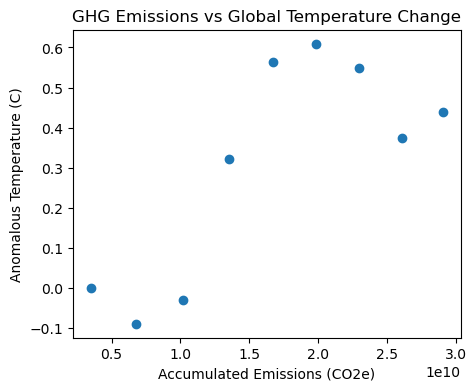

In [19]:
# calculate accumulated emissions by year
emissions_by_year = emissions_hashed.groupby('Year')[['CO2 Emissions']].sum()
emissions_by_year['Accumulated Emissions'] = emissions_by_year['CO2 Emissions'].cumsum()

# merge global emissions with global temp to show global trend
emiss_temp_by_year = my_yearly_df.merge(emissions_by_year, left_on = 'year', right_on = 'Year')

plt.figure(figsize=(5,4))
plt.scatter(emiss_temp_by_year['Accumulated Emissions'], emiss_temp_by_year['TAVG_C_diff'])
plt.title('GHG Emissions vs Global Temperature Change')
plt.xlabel('Accumulated Emissions (CO2e)')
plt.ylabel('Anomalous Temperature (C)');

Let's see if there's more information we can extract from this data!

There are many different types of GHGs. **How do the accumulated GHG emissions compare over time?**

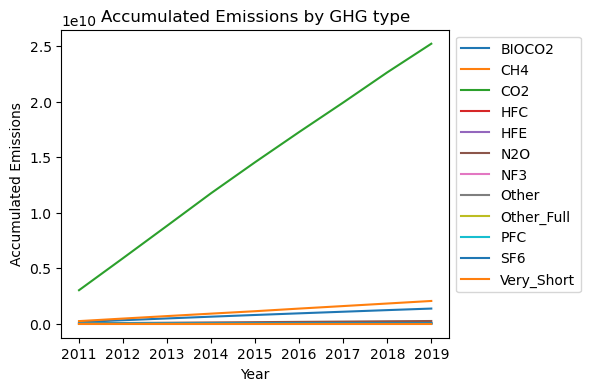

In [20]:
# calculate accumulated emissions by year
emissions_by_yrGHG = emissions_hashed.groupby(['Year','Gas Code'])[['CO2 Emissions']].sum().reset_index()
emissions_by_yrGHG['Accumulated Emissions'] = emissions_by_yrGHG.groupby('Gas Code')['CO2 Emissions'].cumsum()

yrGHG_pivot = emissions_by_yrGHG.pivot(index = 'Year', columns = 'Gas Code', values = 'Accumulated Emissions').dropna(axis=1)
GHG_codes = list(yrGHG_pivot.columns)

yrGHG_pivot.plot(xticks=yrGHG_pivot.index, ylabel='Accumulated Emissions', figsize=(5,4))
plt.title('Accumulated Emissions by GHG type')
plt.legend(bbox_to_anchor =(1, 1));

**How does the local temperature rise depend on local emissions?**

For this, we'll use the anomalous temperatures by region (`regional_df`). To compare on a plot, I've normalized the total GHG emissions in  year for a given region by their respective means since the amount of emissions varies.

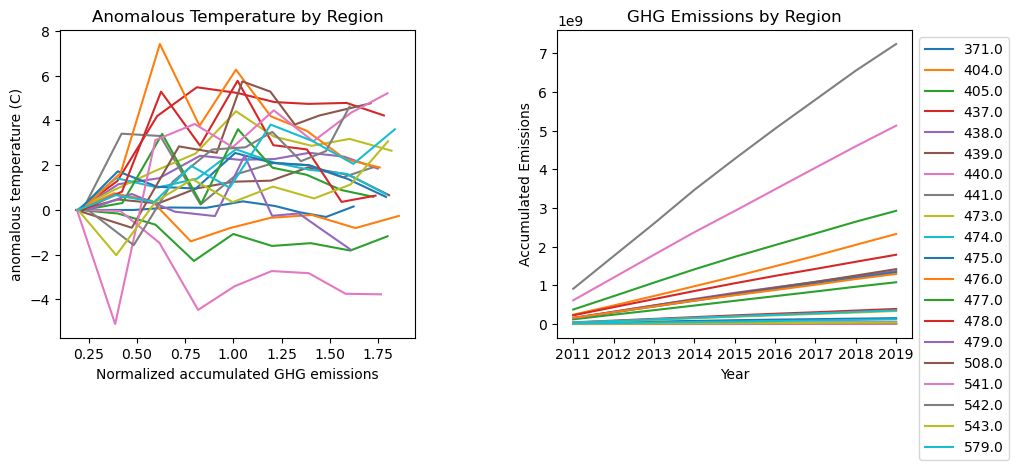

In [21]:
# calculate accumulated emissions by region
emissions_by_yrreg = emissions_hashed.groupby(['Year','my_gh'])[['CO2 Emissions']].sum().reset_index()
emissions_by_yrreg['Accumulated Emissions'] = emissions_by_yrreg.groupby('my_gh')['CO2 Emissions'].cumsum()

# merge emissions data with yearly-by-region-temperature-data
yrGHGreg_pivot = emissions_by_yrreg.pivot(index = 'Year', columns = 'my_gh', values = 'Accumulated Emissions').dropna(axis=1)
us_gh_codes = list(yrGHGreg_pivot.columns)

common_gh_codes = [code for code in us_gh_codes if code in list(regional_pivot.columns)]

yrGHGregT = pd.DataFrame()
plt.figure(figsize=(11,4))
plt.subplots_adjust(wspace=0.4)
ax1 = plt.subplot(1,2,1)
for code in common_gh_codes:
    ax1.plot(yrGHGreg_pivot[code]/yrGHGreg_pivot[code].mean(), regional_pivot[code], label = code)
ax1.set_xlabel('Normalized accumulated GHG emissions')
ax1.set_ylabel('anomalous temperature (C)')
ax1.set_title('Anomalous Temperature by Region')

ax2 = plt.subplot(1,2,2)
yrGHGreg_pivot[common_gh_codes].plot(ax = ax2, xticks=yrGHGreg_pivot.index, ylabel='Accumulated Emissions')
ax2.set_title('GHG Emissions by Region')
ax2.legend(bbox_to_anchor =(1, 1));

Based on the right plot, region 441 has the most emissions over time. **Where is this region?** Using `my_gh_dict`, I can extract the latitude and longitude that form the coordinates for this region and label it on a map. It makes sense there are a lot of emissions in the south-eastern US.

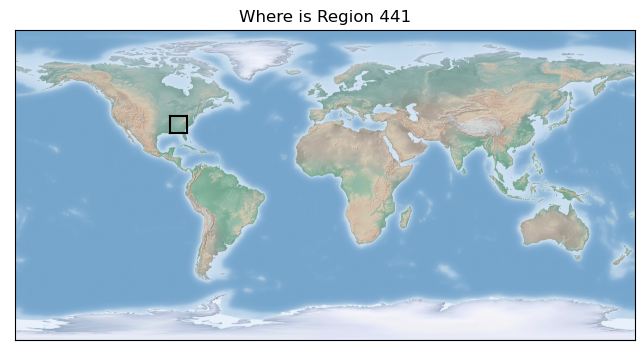

In [22]:
# plot where is region 441 on a map... they got a lot of emissions!
my_gh_dict = create_my_gh_dict()
reg441 = my_gh_dict[441.0]
fig = plt.figure(figsize=(8, 6), edgecolor='w');
m2 = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, );
m2.shadedrelief();
m2.plot(reg441[2:4], [reg441[0],reg441[0]], latlon = True, color="k", linewidth=1.5);
m2.plot(reg441[2:4], [reg441[1],reg441[1]], latlon = True, color="k", linewidth=1.5);
m2.plot([reg441[2],reg441[2]], reg441[0:2], latlon = True, color="k", linewidth=1.5);
m2.plot([reg441[3],reg441[3]], reg441[0:2], latlon = True, color="k", linewidth=1.5);
plt.title('Where is Region 441');

Now that we've explored our data, we can move on to modeling. `emiss_temp_by_year` will be used to model the global anomalous temperature using the accumulated GHG emissions (all gas types).

To see if we can use the gas type as features in addition to accumulated emissions to predict the regional anomalous temperature, we will merge `emissions_hashed` and `regional_df` into `emissions_by_yrGHGreg`.

In [23]:
# calculate accumulated emissions by region and gas type
emissions_by_yrGHGreg = emissions_hashed.groupby(['Year','my_gh','Gas Code'])[['CO2 Emissions']].sum().reset_index()
emissions_by_yrGHGreg['Accumulated Emissions'] = emissions_by_yrGHGreg.groupby(['my_gh','Gas Code'])['CO2 Emissions'].cumsum()
emissions_by_yrGHGreg = emissions_by_yrGHGreg.merge(regional_df, how = 'inner', left_on = ['Year','my_gh'],
                                                    right_on = ['year','my_gh']
                                                   ).dropna().merge(emissions_by_yrGHGreg.groupby(
                                                   ['my_gh','Gas Code'])['Accumulated Emissions'].agg(
                                                   ['mean']).reset_index(),on=['my_gh','Gas Code'])
emissions_by_yrGHGreg['Normalized Accum Emissions'] = emissions_by_yrGHGreg['Accumulated Emissions']/emissions_by_yrGHGreg['mean']
emissions_by_yrGHGreg.head()

,Year,my_gh,Gas Code,CO2 Emissions,Accumulated Emissions,year,TAVG_C,PRCP_mm,TAVG_C_diff,PRCP_diff,mean,Normalized Accum Emissions
0,2011,371.0,CH4,2.013504e+06,2.013504e+06,2011,26.822176,5.487108,0.000000,0.000000,6.032917e+06,0.333753
1,2012,371.0,CH4,1.095818e+06,3.109322e+06,2012,26.822086,4.939543,-0.000091,-0.547565,6.032917e+06,0.515393
2,2013,371.0,CH4,1.122120e+06,4.231442e+06,2013,26.932292,4.320747,0.110115,-1.166362,6.032917e+06,0.701392
3,2014,371.0,CH4,9.792500e+05,5.210692e+06,2014,26.918352,3.914732,0.096176,-1.572377,6.032917e+06,0.863710
4,2015,371.0,CH4,9.015492e+05,6.112241e+06,2015,27.207077,4.656710,0.384901,-0.830399,6.032917e+06,1.013149


## Modeling
We will use a simple linear regression model for this quantitative data. Given our knowledge about the causes of climate change, let's predict the anomalous temperature given GHG emissions. First, we will try modeling regional anomalous temperture given gas type and accumulated emissions.

Regional Model
Training RMSE: 2.1374065091718064
Test RMSE: 2.13580301459634

Model
θ0: 0.45472524575792783
θ1: [ 0.84878684 -0.9328702  -6.29944435  0.64752991  0.99442678  7.20620121
 -1.04048791 -0.26541318 -0.23357811  1.101067   -1.0269899  -0.49011277]
Gases:  ['BIOCO2', 'CH4', 'CO2', 'HFC', 'HFE', 'N2O', 'NF3', 'Other', 'Other_Full', 'PFC', 'SF6', 'Very_Short']


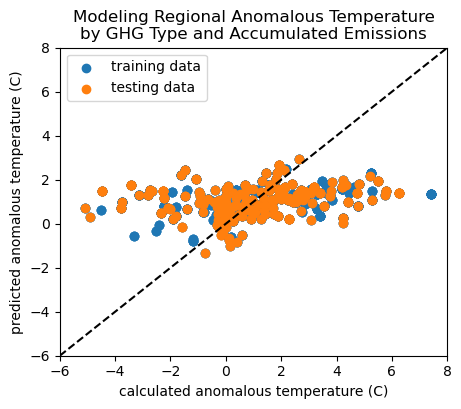

In [24]:
# calculating local temperature change by normalized local emissions & gas type
# we know this to be untrue though since most affected places are
# from developing countries and the US puts out a lot of emissions

reg_df = emissions_by_yrGHGreg[['Year','my_gh','Gas Code','TAVG_C_diff','Normalized Accum Emissions']].pivot(
    index = ['Year','my_gh'],columns = ['Gas Code'], values = ['Normalized Accum Emissions']).fillna(
    0).reset_index().merge(emissions_by_yrGHGreg[['Year','my_gh','TAVG_C_diff']], on = ['Year','my_gh'])
reg_X = reg_df.iloc[:,4:16]
reg_Y = reg_df['TAVG_C_diff']
reg_train_x, reg_test_x, reg_train_y, reg_test_y = train_test_split(reg_X, reg_Y, test_size = 0.2)

# Initialize and fit the  model
reg_linear_model = lm.LinearRegression(fit_intercept=True)
reg_linear_model.fit(reg_train_x, reg_train_y) 
reg_pred_train_y = reg_linear_model.predict(reg_train_x) 
reg_pred_test_y = reg_linear_model.predict(reg_test_x)

#Computing the Root Mean Squared Error for our model
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

#Getting the training and test errors for our model
train_error = rmse(reg_pred_train_y, reg_train_y)
test_error = rmse(reg_pred_test_y, reg_test_y)
print("Regional Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(train_error, test_error))
# Extracting parameters from our model
reg_theta0 = reg_linear_model.intercept_
reg_theta1 = reg_linear_model.coef_
print("Model\nθ0: {}\nθ1: {}".format(reg_theta0, reg_theta1))
gases = [x[1] for x in reg_df.columns[4:16]]
print("Gases: ", gases)

plt.figure(figsize=(5,4))
plt.scatter(reg_train_y, reg_pred_train_y, label = 'training data')
plt.scatter(reg_test_y, reg_pred_test_y, label = 'testing data')
plt.xlabel('calculated anomalous temperature (C)')
plt.ylabel('predicted anomalous temperature (C)')
plt.plot([-6, 8],[-6, 8],'k--')
plt.xlim([-6, 8])
plt.ylim([-6, 8])
plt.title('Modeling Regional Anomalous Temperature\nby GHG Type and Accumulated Emissions')
plt.legend();

We don't get a good fit. This makes sense, since increasing emissions and anomalous temperature have affected developing countries more than countries like the US with high emissions.

Instead, let's look at the impact of total accumulated GHG emissions on the global anomalous temperature.

Global Model
Training RMSE: 0.16611315878086869
Test RMSE: 0.1897162303199443



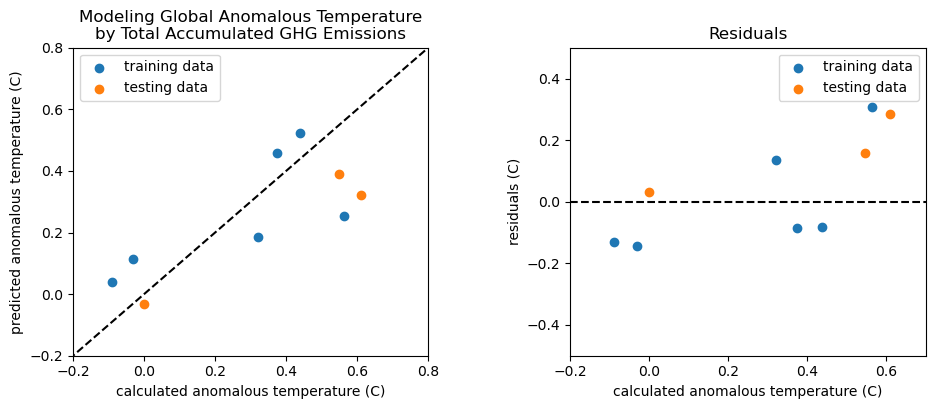

In [25]:
# calculating global temperature change by US emissions

global_X = emiss_temp_by_year[['Accumulated Emissions']]
global_Y = emiss_temp_by_year['TAVG_C_diff']
global_train_x, global_test_x, global_train_y, global_test_y = train_test_split(global_X, global_Y, test_size = 0.33)

#Initialize and fit the linear regression object
global_linear_model = lm.LinearRegression(fit_intercept=True)
global_linear_model.fit(global_train_x, global_train_y) 
global_pred_train_y = global_linear_model.predict(global_train_x) 
global_pred_test_y = global_linear_model.predict(global_test_x)

#Getting the training and test errors for our model
global_train_error = rmse(global_pred_train_y, global_train_y)
global_test_error = rmse(global_pred_test_y, global_test_y)
print("Global Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(global_train_error, global_test_error))

plt.figure(1,figsize=(11,4))
plt.subplots_adjust(wspace=0.4)

ax1 = plt.subplot(1,2,1)
ax1.scatter(global_train_y, global_pred_train_y, label = 'training data')
ax1.scatter(global_test_y, global_pred_test_y, label = 'testing data')
ax1.set_xlabel('calculated anomalous temperature (C)')
ax1.set_ylabel('predicted anomalous temperature (C)')
ax1.plot([-1, 1],[-1, 1],'k--')
ax1.set_xlim([-0.2, 0.8])
ax1.set_ylim([-0.2, 0.8])
ax1.set_title('Modeling Global Anomalous Temperature\nby Total Accumulated GHG Emissions')
ax1.legend();

# residuals plot
global_residuals_train = global_train_y - global_pred_train_y
global_residuals_test = global_test_y - global_pred_test_y

ax2 = plt.subplot(1,2,2)
ax2.scatter(global_train_y, global_residuals_train, label = 'training data')
ax2.scatter(global_test_y, global_residuals_test, label = 'testing data')
ax2.set_xlabel('calculated anomalous temperature (C)')
ax2.set_ylabel('residuals (C)')
ax2.plot([-0.2, 0.7],[0, 0],'k--')
ax2.set_xlim([-0.2, 0.7])
ax2.set_ylim([-0.5, 0.5])
ax2.set_title('Residuals')
ax2.legend();

We get a much better fit! Note that the above does not account for emissions by other countries.

However, this result still demonstrates the US has a significant impact on global temperature rise!

### fin.